In [28]:
import pysindy as ps
from data._main import get_dataset
from omegaconf import OmegaConf
from utils import NEURONS_302
import numpy as np
from testing.leandro.plots import *
from scipy.integrate import solve_ivp

In [2]:
config = OmegaConf.load("/om2/user/lrvenan/worm-graph/conf/dataset.yaml")
dataset = get_dataset(config)

Chosen dataset(s): ['Uzel2022']
Num. worms: 6



In [3]:
oneWorm = dataset['worm0']
oneWorm.keys()

dict_keys(['dataset', 'smooth_method', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [4]:
X = oneWorm['calcium_data'].detach().numpy()
dt = oneWorm['dt']
print('X shape: {}, dt: {}'.format(X.shape, dt))

X shape: (10797, 302), dt: 0.1


In [5]:
active_neurons = oneWorm['named_neurons_mask']
X_active = X[:, active_neurons]
name_active_neurons = [NEURONS_302[i] for i in range(len(active_neurons)) if active_neurons[i]]

print('Active neurons shape: {}'.format(X_active.shape))
print('Names:')
for n in name_active_neurons:
    print(n, end=', ')

Active neurons shape: (10797, 58)
Names:
AIBL, AIBR, ALA, ALNL, ALNR, AS10, ASKL, ASKR, AVAL, AVAR, AVBL, AVBR, AVEL, AVER, AVFL, AVFR, DA1, DA7, DA9, DB1, DB2, DB7, DVA, DVC, PDA, PHAR, PVNL, PVNR, RIBL, RIBR, RID, RIMR, RIS, RIVR, RMED, RMEL, RMEV, SABD, SABVL, SABVR, SIADL, SIADR, SIAVL, SIAVR, SMDDL, SMDDR, SMDVR, URYDL, URYDR, URYVL, URYVR, VA1, VA11, VA12, VB1, VB11, VB2, VD13, 

In [6]:
# Check if we have data of some neurons

searched_neurons = ['AIY', 'AVA', 'AVB', 'RIF', 'SMD', 'DVC']

for n in searched_neurons:
    if n in name_active_neurons:
        print('Found {}'.format(n))
    else:
        print('Not found {}'.format(n))

np.where(np.array(name_active_neurons) == 'DVC')

Not found AIY
Not found AVA
Not found AVB
Not found RIF
Not found SMD
Found DVC


(array([23]),)

In [7]:
fr_library_functions = [
    lambda x, y: -x + np.tanh(y),
]

fr_library_functions_names = [
    lambda x, y: '-' + x + 'tanh(' + y + ')',
]

mylib = ps.CustomLibrary(
    library_functions=fr_library_functions,
    function_names=fr_library_functions_names
)

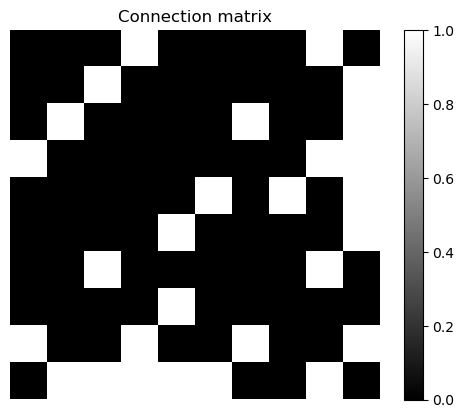

In [8]:
# Connection matrix
def dual_connection_matrix(size, ratio=0.5):
    matrix = np.random.choice([True, False], size=(size, size))
    # Mask upper triangle
    matrix = np.triu(matrix)

    # Connections created
    n_connections = int(np.sum(matrix))
    connected_positions = np.where(matrix==True)
    
    while (n_connections/(size**2) >= ratio):
        # Remove connections
        pos = np.random.choice(np.arange(len(connected_positions[0])), size=1)[0]
        matrix[connected_positions[0][pos], connected_positions[1][pos]] = False
        n_connections = int(np.sum(matrix))
        connected_positions = np.where(matrix==True)

    # Reflect w.r.t principal diagonal
    matrix = matrix.T | matrix
    # No self connections
    np.fill_diagonal(matrix, False)
    return matrix

def plot_matrix(matrix, title):
    plt.imshow(matrix, cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.axis('off')  # Remove x and y labels
    plt.show()

plot_matrix(dual_connection_matrix(10, 0.2), 'Connection matrix')

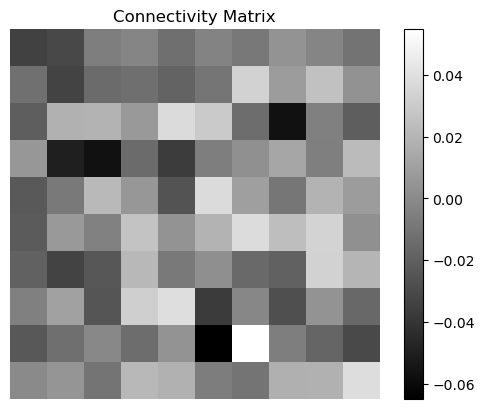

In [9]:
def generate_connectivity_matrix(num_neurons, g):
    # g = gain (scaling factor), g < 1 -> inactive, g > 1 -> spontaneous activity
    # inhibitory connections are negative
    # excitatory connections are positive
    return np.random.normal(0, (g**2) / num_neurons, size=(num_neurons, num_neurons))

plot_matrix(generate_connectivity_matrix(10, 0.5), 'Connectivity Matrix')

In [21]:
# Synaptic input
def synaptic_input(J, x):
    # J: connectivity matrix -> (source_neurons, target_neurons)
    # x: vector of neuron activities (num_neurons,)
    return J.T @ x

n_neurons = 4
X = np.random.normal(0, 1, size=(n_neurons,))
print(X)
J = dual_connection_matrix(n_neurons, 0.2)
print(J*1)
I = synaptic_input(X, J)
print(I)

[ 1.0230276  -2.96452019  0.19897248 -0.04376768]
[[0 1 0 1]
 [1 0 0 0]
 [0 0 0 0]
 [1 0 0 0]]
[-3.00828786  1.0230276   0.          1.0230276 ]


In [63]:
def neural_activity(t, x, tau):
    n_neurons = len(x)
    J = generate_connectivity_matrix(n_neurons, 1.5)
    return (1/tau)*(-x + J @ np.tanh(x))

n_neurons = 302
x0 = np.random.choice([-1, 0, 1], size=(n_neurons,))
tau = 1
t = [0, 1]

sol = solve_ivp(neural_activity, t, x0, args=(tau,), method='RK23')
plt.plot(sol.t, sol.y.T)
plt.show()

KeyboardInterrupt: 

In [80]:
# Subset of neurons to test
num_test_neurons = 27
max_timesteps = 1000
feature_names = ['x'+str(i) for i in range(num_test_neurons)]

# Add a neuron that we know it is connected
X_train = X_active[:max_timesteps, :num_test_neurons]
X_train = np.concatenate((X_train, X_active[:max_timesteps, 23:24]), axis=1)
feature_names.append('x28')

# Create a SINDy model
opt = ps.STLSQ(threshold=0.02) 
model = ps.SINDy(feature_names=feature_names, feature_library=mylib, optimizer=opt)
model.fit(X_train, t=dt)
model.print()

(x0)' = 0.304 -x0tanh(x1) + 0.251 -x0tanh(x2) + -0.109 -x0tanh(x5) + -0.101 -x0tanh(x6) + -0.004 -x0tanh(x7) + -0.103 -x0tanh(x9) + 0.022 -x0tanh(x10) + -0.439 -x0tanh(x11) + -0.264 -x0tanh(x13) + 0.049 -x0tanh(x15) + 0.297 -x0tanh(x16) + 0.088 -x0tanh(x17) + 0.696 -x0tanh(x19) + -0.151 -x0tanh(x20) + -0.615 -x0tanh(x21) + 0.166 -x0tanh(x22) + -0.054 -x0tanh(x24) + -0.128 -x0tanh(x25) + -0.077 -x0tanh(x26) + 0.241 -x1tanh(x2) + 0.013 -x1tanh(x3) + -0.120 -x1tanh(x5) + -0.111 -x1tanh(x6) + -0.015 -x1tanh(x7) + -0.028 -x1tanh(x8) + -0.113 -x1tanh(x9) + 0.012 -x1tanh(x10) + -0.449 -x1tanh(x11) + -0.021 -x1tanh(x12) + -0.275 -x1tanh(x13) + 0.085 -x1tanh(x14) + 0.039 -x1tanh(x15) + 0.287 -x1tanh(x16) + 0.078 -x1tanh(x17) + 0.686 -x1tanh(x19) + 0.156 -x1tanh(x22) + -0.138 -x1tanh(x25) + 0.017 -x2tanh(x3) + -0.115 -x2tanh(x5) + -0.107 -x2tanh(x6) + -0.010 -x2tanh(x7) + -0.023 -x2tanh(x8) + -0.109 -x2tanh(x9) + 0.016 -x2tanh(x10) + -0.445 -x2tanh(x11) + -0.017 -x2tanh(x12) + -0.270 -x2tanh(x13

In [81]:
x0 = X_train[0, :]
t = oneWorm['time_in_seconds'].detach().numpy().squeeze()
t = t[:max_timesteps]
sim = model.simulate(x0, t=t)

In [77]:
plot_signals(torch.tensor(X_train), oneWorm['time_in_seconds'].squeeze(), 3)

AssertionError: Number of rows in data and time_tensor must match

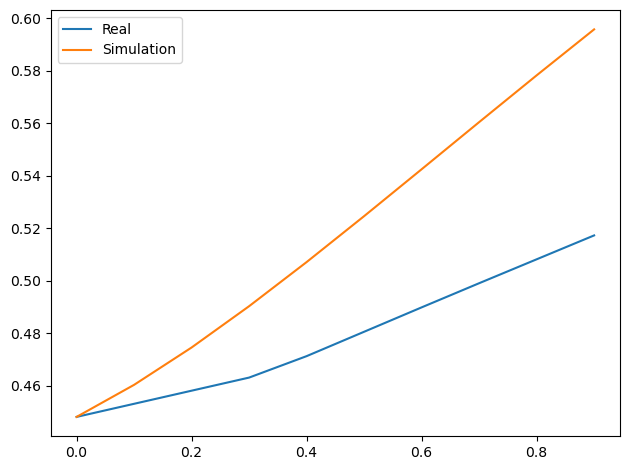

In [87]:
neuron_number = 1
plt.plot(t[:10], X_train[:10, neuron_number], label='Real')
plt.plot(t[:10], sim[:10, neuron_number], label='Simulation')
plt.legend()
plt.tight_layout()
plt.show()